<a href="https://colab.research.google.com/github/romanzm13/Analisis_Datos_Defunciones_Jalisco_por_Region/blob/main/AnalisisDefuncionesRegionesJalisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xlrd==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 2.0.1
    Uninstalling xlrd-2.0.1:
      Successfully uninstalled xlrd-2.0.1


In [2]:
!pip install geopandas

In [3]:
from numpy import count_nonzero,arange,array,dot,asarray,zeros,apply_along_axis,around,sort,shape,savetxt,array_equal,max,argmin,argmax,fill_diagonal,ones,argsort,std,diag,random
from matplotlib.pyplot import plot,figure,title,legend,xlabel,ylabel,grid,axhline,axvline,savefig,imshow,show,scatter,hist,bar,subplot,subplots,cm,Normalize,text,tick_params
from math import sqrt
import pandas as pd
from datetime import datetime,timedelta
from scipy.stats.mstats import mquantiles
from statistics import mean,median,mode
from scipy.stats import poisson
from copy import deepcopy
import matplotlib.patches as mpatches
import geopandas
pd.options.display.max_rows=10

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importar datos geométricos para crear mapas de Jalisco

In [5]:
mun_jal_map=geopandas.read_file(r'/content/drive/MyDrive/TESIS_DOCTORADO/LimiteMunicipal_MGJ2012_modificadoDecreto26837.shp')

In [6]:
mun_jal_map.head()

,OBJECTID,NOMBRE,REGIÓN,CLAVE,km2,DESCRIPCIO,geometry
0,1,ACATIC,ALTOS SUR,1,327.559764,"Mapa General de Jalisco 2012, publicado en el ...","POLYGON ((718057.000 2286115.998, 718075.000 2..."
1,2,ACATLÁN DE JUÁREZ,LAGUNAS,2,181.291050,"Mapa General de Jalisco 2012, publicado en el ...","POLYGON ((648150.205 2264785.823, 648182.724 2..."
2,3,AHUALULCO DE MERCADO,VALLES,3,235.255893,"Mapa General de Jalisco 2012, publicado en el ...","POLYGON ((612445.425 2280035.018, 612332.866 2..."
3,4,AMACUECA,LAGUNAS,4,132.379915,"Mapa General de Jalisco 2012, publicado en el ...","POLYGON ((638908.600 2208601.532, 638942.475 2..."
4,5,AMATITÁN,VALLES,5,216.059719,"Mapa General de Jalisco 2012, publicado en el ...","POLYGON ((640648.182 2310968.738, 640688.399 2..."


Importar datos filtrados

El conjunto de datos utilizado a continuación está filtrado a partir de los datos abiertos del INEGI disponibles en:

Subsistema de Información Demográfica y Social. (2021). *Defunciones registradas (mortalidad general)*. Recuperado de https://www.inegi.org.mx/programas/mortalidad/#Datos_abiertos

In [7]:

df=pd.read_csv('/content/drive/MyDrive/DATOS_INEGI_DEFUNCIONES/Datos_filtrados_defunciones_2021.csv')

print("Tamaño de la base de datos:")
print(df.shape)
print("Información general de los datos:")
print(df.info())
#Cuántos diferentes valores posee cada variable
print("Cantidad de valores diferentes para cada variable:")
print(df.nunique())
#Verificar si hay valores nulos
print("Valores nulos en cada variable")
print(df.isnull().sum())

Tamaño de la base de datos:
(74233, 7)
Información general de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74233 entries, 0 to 74232
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   mun_resid   74233 non-null  int64
 1   lugar_ocur  74233 non-null  int64
 2   asist_medi  74233 non-null  int64
 3   sitio_ocur  74233 non-null  int64
 4   derechohab  74233 non-null  int64
 5   edad_agru   74233 non-null  int64
 6   No_Region   74233 non-null  int64
dtypes: int64(7)
memory usage: 4.0 MB
None
Cantidad de valores diferentes para cada variable:
mun_resid     125
lugar_ocur     11
asist_medi      3
sitio_ocur     13
derechohab     10
edad_agru      28
No_Region      12
dtype: int64
Valores nulos en cada variable
mun_resid     0
lugar_ocur    0
asist_medi    0
sitio_ocur    0
derechohab    0
edad_agru     0
No_Region     0
dtype: int64


In [8]:
#Importar los datos sobre la regionalización de Jalisco
df_reg=pd.read_excel("/content/drive/MyDrive/DATOS_INEGI_DEFUNCIONES/Regionalizacion_Jalisco.xlsx",sheet_name="por_municipio")

df_reg['Municipio']=df_reg['Municipio'].astype(str)
df_reg['Region']=df_reg['Region'].astype(str)

print("Información general de los datos:")
print(df_reg.info())
#Cuántos diferentes valores posee cada variable
print("Cantidad de valores diferentes para cada variable:")
print(df_reg.nunique())

Información general de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Clave       125 non-null    int64 
 1   Municipio   125 non-null    object
 2   Habitantes  125 non-null    int64 
 3   No_Region   125 non-null    int64 
 4   Region      125 non-null    object
dtypes: int64(3), object(2)
memory usage: 5.0+ KB
None
Cantidad de valores diferentes para cada variable:
Clave         125
Municipio     125
Habitantes    125
No_Region      12
Region         12
dtype: int64


#Calcular número de habitantes por región socieconómica y extraer el nombre de cada región

In [9]:
#Obtener número de habitantes por cada región socieconómica de Jalisco
pob_reg=df_reg.groupby(['No_Region ']).agg({'Habitantes': 'sum'}).reset_index()
#Extraer nombres de las regiones socioeconómicas
nombre_reg=df_reg['Region'].unique()
num_reg=df_reg['No_Region '].unique()
df_nombre_reg=pd.DataFrame(num_reg,columns=['No_Region '])
df_nombre_reg['Region']=nombre_reg
#Ordenar el dataframe de acuerdo a el número de región
df_nombre_reg=df_nombre_reg.sort_values(by='No_Region ')
#Nombres de las regiones ordenados de acuerdo al número de la región
nombres=df_nombre_reg['Region']

#Contabilizar número de defunciones por región socieconómica en el 2021

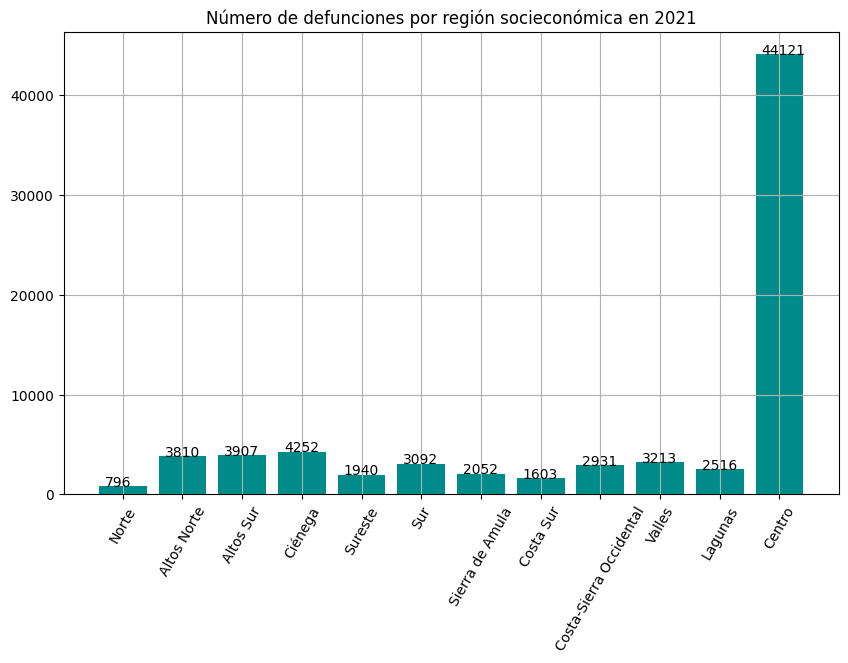

In [10]:
#Obtener número de habitantes por cada región socieconómica de Jalisco
defunc_reg=df.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
defunc=defunc_reg['mun_resid']
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,defunc,color='darkcyan')
title("Número de defunciones por región socieconómica en 2021")
tick_params(axis='x', rotation=60)
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,defunc[i],defunc[i],color="k")
grid()

Cuando se consideran cantidades netas o absolutas es claro que la región Centro, donde se encuentra la Zona Metropolitana de Guadalajara y que por mucho es el centro urbano más grande del estado, es la que registró mayor número de defunciones. De hecho, el número de defunciones correspondientes a esta región es alrededor de 10 veces el número registrado en cada una de las demás regiones.

#Número de defunciones por 100,000 habitantes en cada región (con lo cual se evita el sesgo por el tamaño de la población)

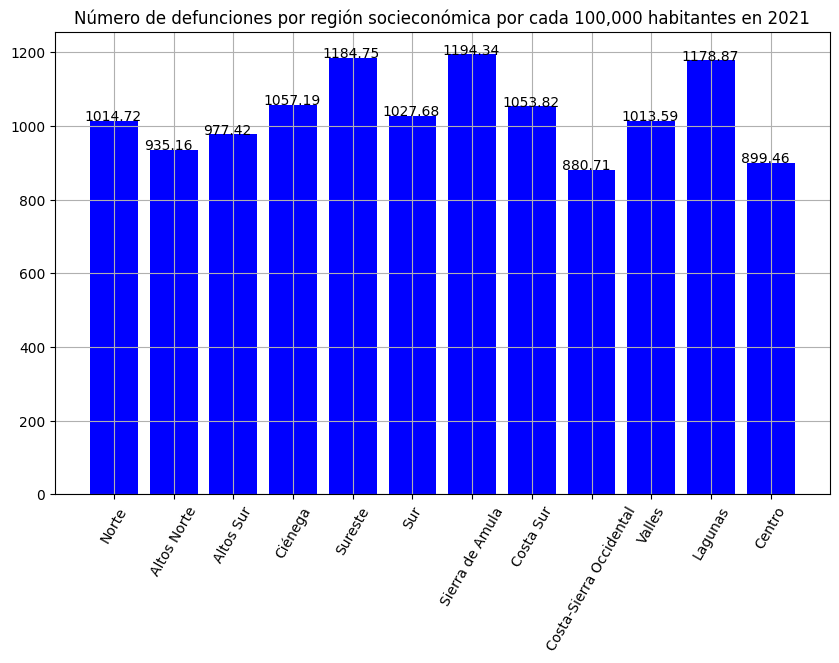

In [11]:
defunc_norm=(defunc_reg['mun_resid']/pob_reg['Habitantes'])*100000
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,defunc_norm,color='blue')
title("Número de defunciones por región socieconómica por cada 100,000 habitantes en 2021")
tick_params(axis='x', rotation=60)
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.5,defunc_norm[i],str(round(defunc_norm[i],2)),color="k")
grid()

Con la intención de corregir el sesgo provocado por las diferencias tan marcadas entre el número de habitantes de las regiones, se calculó ahora el número de defunciones por cada 100,000 habitantes en cada región.\
En este caso, vemos que incluso la región Centro es de las que menos defunciones registró por cada 100,000 habitantes. Sin embargo, en general el número de defunciones por cada 100,000 habitantes no varía mucho por región, como sí lo hacía el número absoluto.

Representar los mismos resultados a través de un mapa

In [12]:
#Transformar el número de región de acuerdo al etiquetado del archivos shp del INEGI referente a los polígonos
def transf_num_reg(num_reg_mun):
    #Etiquetas de los municipios que maneja el archivos shp del INEGI
    new_etiq=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,
              124,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123]
    n_mun=125
    new_reg_mun=zeros((n_mun))
    for i in range(0,n_mun):
        new_reg_mun[new_etiq[i]]=num_reg_mun[i]
    return new_reg_mun

def asign_por_mun(caract,num_reg_mun):
      #Número de municipios
      n_mun=125
      caract_mun=zeros((n_mun))
      for i in range(0,n_mun):
            caract_mun[i]=caract[num_reg_mun[i]-1]
      return caract_mun

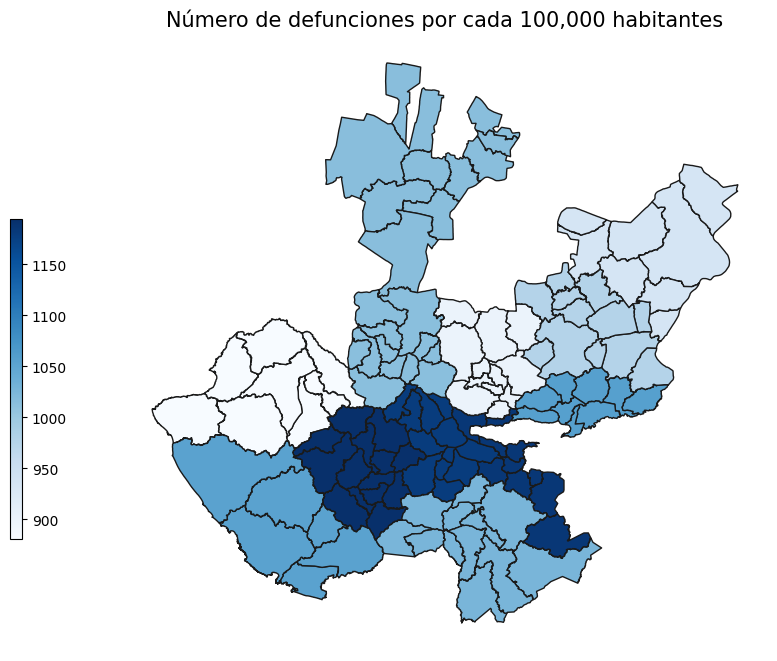

In [13]:
num_reg_mod=transf_num_reg(df_reg['No_Region '])
defunc_norm_mun=asign_por_mun(defunc_norm,num_reg_mod)
mun_jal_map['Defunc_norm']=defunc_norm_mun
#Set the range for the choropleth
titulo='Número de defunciones por cada 100,000 habitantes'
col='Defunc_norm'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='Blues'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

#Porcentaje de defunciones en las que sí hubo asistencia médica por región socioeconómica

In [14]:
#Los casos no especificados no se van a considerar
#Obtener aquellos registros referentes a casos donde sí hubo asistencia médica
df_asist_med=df[df['asist_medi']==1]
#Obtener aquellos registros referentes a casos donde no hubo asistencia médica
df_no_asist_med=df[df['asist_medi']==2]
#Registros de casos donde sí hubo asistencia médica por cada región socieconómica de Jalisco
df_asist_med_reg=df_asist_med.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Registros de casos donde sí hubo asistencia médica por cada región socieconómica de Jalisco
df_no_asist_med_reg=df_no_asist_med.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Calcular el porcentaje de defunciones en las que sí hubo asistencia médica
porc_asist_med_reg=df_asist_med_reg['mun_resid']/(df_asist_med_reg['mun_resid']+df_no_asist_med_reg['mun_resid'])*100

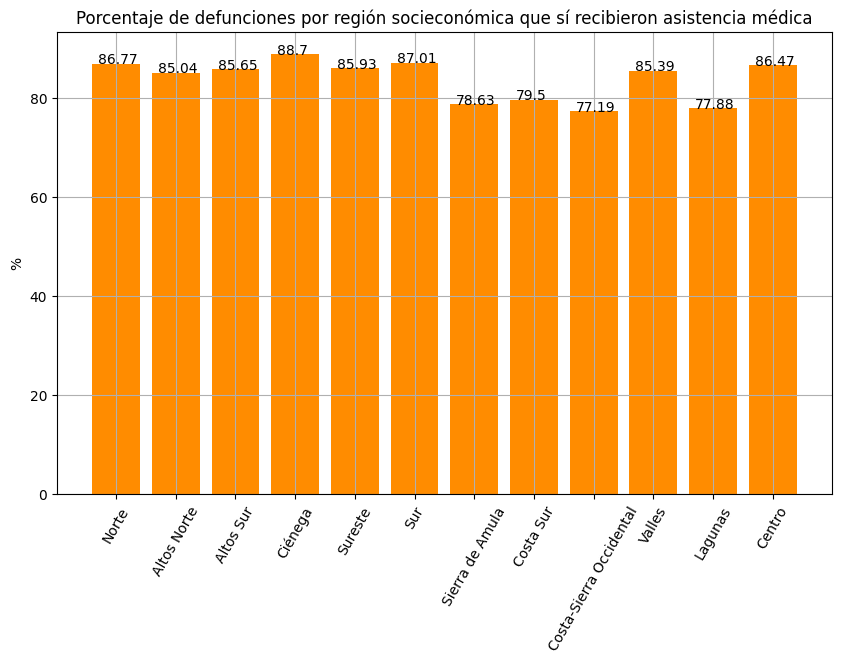

In [15]:
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,porc_asist_med_reg,color='darkorange')
title("Porcentaje de defunciones por región socieconómica que sí recibieron asistencia médica")
tick_params(axis='x', rotation=60)
ylabel('%')
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,porc_asist_med_reg[i],str(round(porc_asist_med_reg[i],2)),color="k")
grid()

De aquí en adelante, para evitar sesgos en la información debido al número de registros por cada región, se calcularán cantidades porcentuales y no absolutas.
En la gráfica anterior, observamos que el porcentaje de fallecidos que sí recibieron asistencia médica no varía mucho de una región a otra, encontrándose en todos los casos cercano al 80%.

Representar los resultaados a través de un mapa

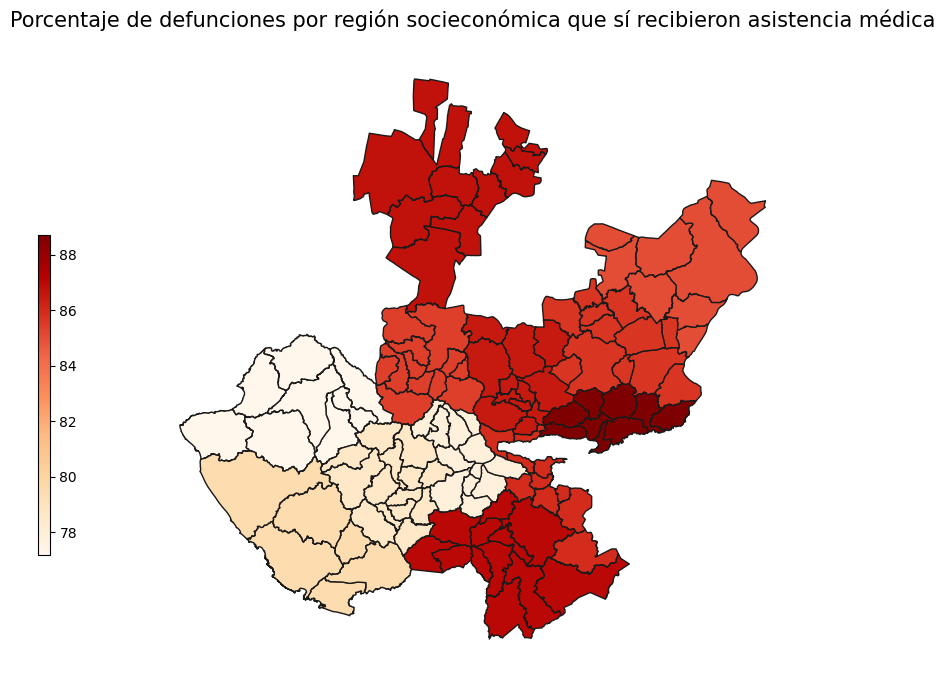

In [16]:
porc_asist_med_mun=asign_por_mun(porc_asist_med_reg,num_reg_mod)
mun_jal_map['Asistencia_medica']=porc_asist_med_mun
#Set the range for the choropleth
titulo='Porcentaje de defunciones por región socieconómica que sí recibieron asistencia médica'
col='Asistencia_medica'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='OrRd'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

#Porcentaje de fallecidos que sí eran derechohabientes de alguna institución de salud

In [17]:
#Los casos no especificados no se van a considerar
df_derecho=df[df['derechohab']!=99]
#Contabilizar el total de registros en el dataframe anterior por región socioeconómica
count_derecho=df_derecho.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Registros de aquellos que no eran derechohabientes
df_sin_derecho=df_derecho[df_derecho['derechohab']==1]
count_sin_derecho=df_sin_derecho.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Calcular el porcentaje de defunciones en las que sí hubo asistencia médica
porc_con_der_reg=(count_derecho['mun_resid']-count_sin_derecho['mun_resid'])/(count_derecho['mun_resid'])*100

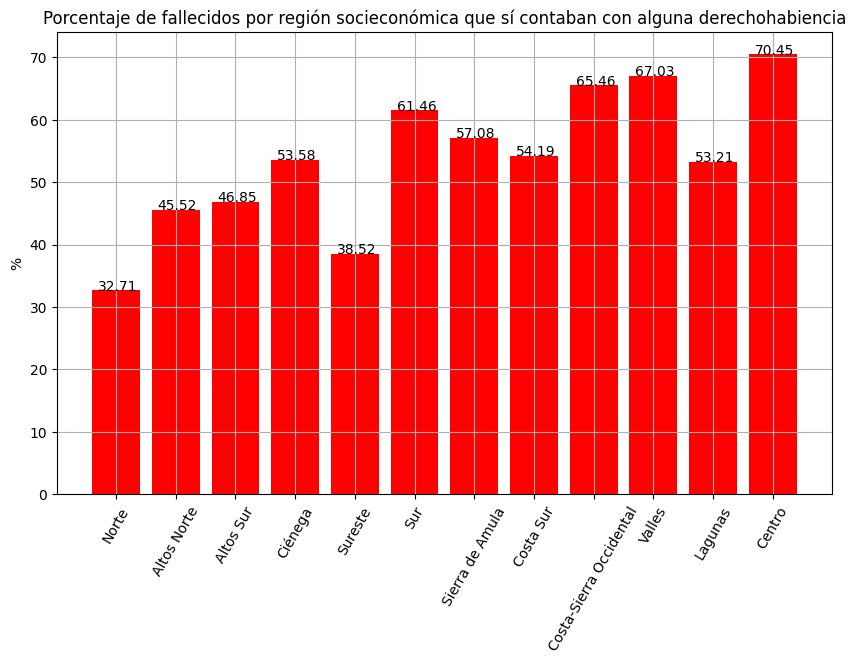

In [18]:
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,porc_con_der_reg,color='red')
title("Porcentaje de fallecidos por región socieconómica que sí contaban con alguna derechohabiencia")
tick_params(axis='x', rotation=60)
ylabel('%')
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,porc_con_der_reg[i],str(round(porc_con_der_reg[i],2)),color="k")
grid()

Por otro lado, respecto al porcentaje de fallecidos que contaban con derechohabiencia a algún servicio de salud público, sí encontramos diferencias importantes entre las regiones. Las regiones Centro (donde está la Zona Metropolitana de Guadalajara), Valles (donde se encuentran municipios como Tequila y Ameca, y que es cercana a la Zona Metropolitana) y Costa-Sierra Occidental (a la que pertenece Puerto Vallarta), son las que muestran los porcentajes más altos. Esto podría estar correlacionado con el hecho de que en estas regiones los habitantes tienes más fácil acceso a los servicios públicos.\
En contraste, las regiones Norte y Sureste poseen porcentajes muy bajos. En el caso de la región Norte, esta se encuentra compuesta por comunidades aisladas y que son de difícil acceso vía terrestre desde las demás zonas geográficas de Jalisco debido a la presencia de la Sierra Madre Occidental. Respecto a la región Sureste, es importante destacar que más de la mitad de los municipios de esta región son poblaciones pequeñas y aisladas. En ambos casos, esto puede obstaculizar el acceso de los habitantes de esta región a servicios de salud.

Representar los mismos resultados a través de un mapa

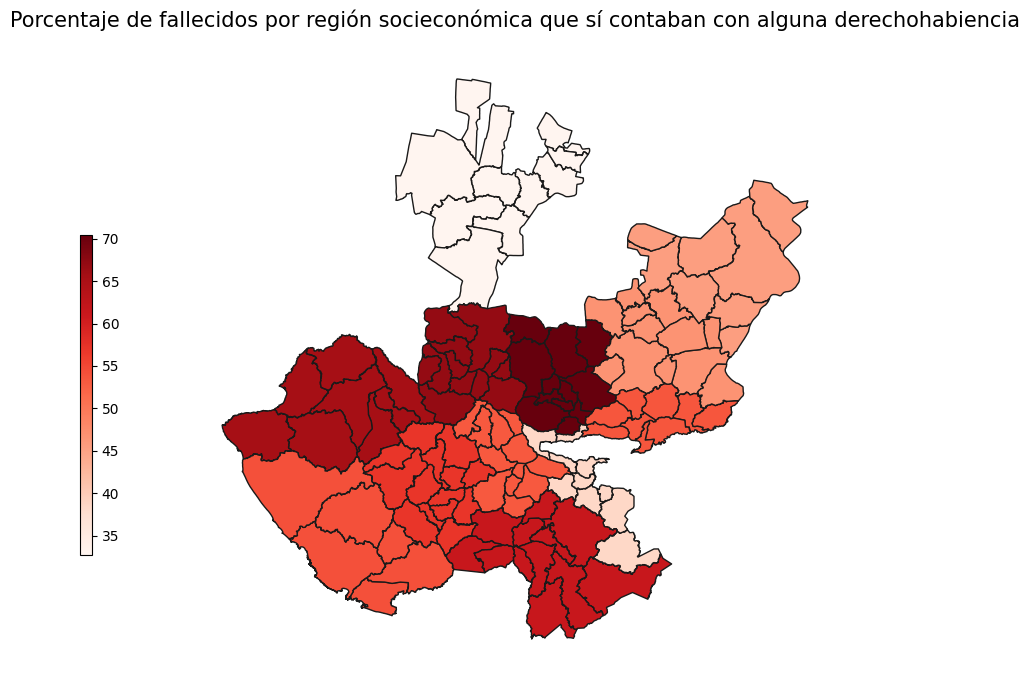

In [19]:
porc_con_der_mun=asign_por_mun(porc_con_der_reg,num_reg_mod)
mun_jal_map['Con_derechohabiencia']=porc_con_der_mun
#Set the range for the choropleth
titulo='Porcentaje de fallecidos por región socieconómica que sí contaban con alguna derechohabiencia'
col='Con_derechohabiencia'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='Reds'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

#Porcentaje de cada lugar de ocurrencia por región socioeconómica

In [20]:
#Los casos no especificados no se van a considerar
df_sitio=df[df['sitio_ocur']!=99]
#Contabilizar el total de registros en el dataframe anterior por región socioeconómica
count_sitio=df_sitio.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()

Registros de aquellos que fallecieron en alguna unidad de salud pública (Secretaría de Salud, IMSS PROSPERA, IMSS, ISSTE, PEMEX, SEDENA, Secretaría de Marina, Otra Unidad Pública)

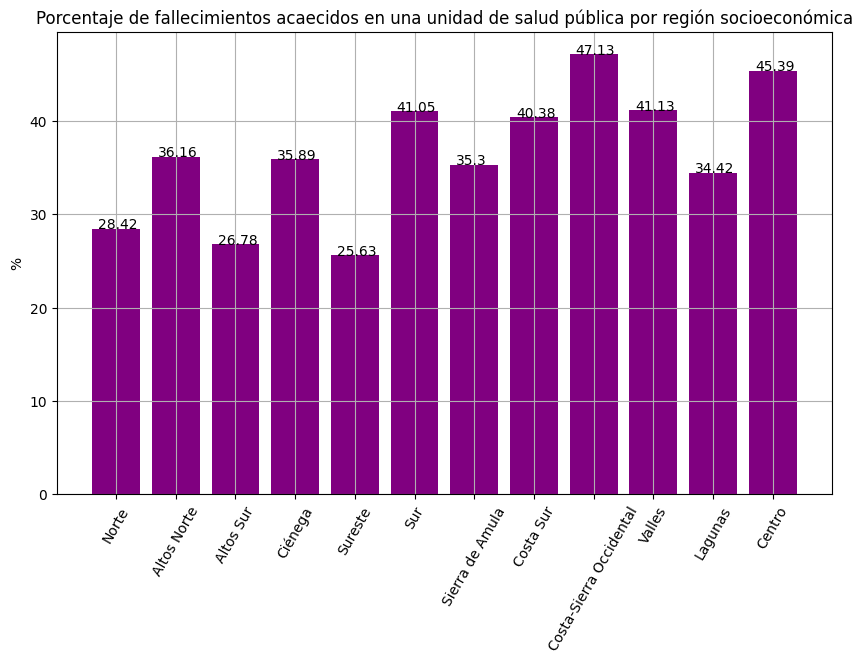

In [21]:
df_salud_pub=df_sitio[df_sitio['sitio_ocur']<9]
count_salud_pub=df_salud_pub.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Calcular el porcentaje de defunciones acaecidas en una unidad de salud pública
porc_salud_pub_reg=(count_salud_pub['mun_resid']/count_sitio['mun_resid'])*100
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,porc_salud_pub_reg,color='purple')
title("Porcentaje de fallecimientos acaecidos en una unidad de salud pública por región socioeconómica")
tick_params(axis='x', rotation=60)
ylabel('%')
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,porc_salud_pub_reg[i],str(round(porc_salud_pub_reg[i],2)),color="k")
grid()

De forma similar a la gráfica de porcentaje de derechohabiencia, las regiones Centro y Costa-Sierra Occidental son los que presentan los valores más altos de fallecimientos ocurridos en unidades de salud pública. Esto podría apoyar la hipótesis de que la accesibilidad a servicios de salud públicos es mejor en estas regiones, y más aún, que la atención en situaciones de emergencia es más rápida.\
Por otra parte, nuevamente la región Sureste presenta un porcentaje muy bajo, lo que nos podría indicar que efectivamente el acceso a servicios de salud públicos es complicado. Lo que resulta interesante es que en este caso la región Altos Sur muestra el segundo porcentaje más bajo, sólo por arriba de la región Sureste.

Representar los mismos resultados a través del mapa

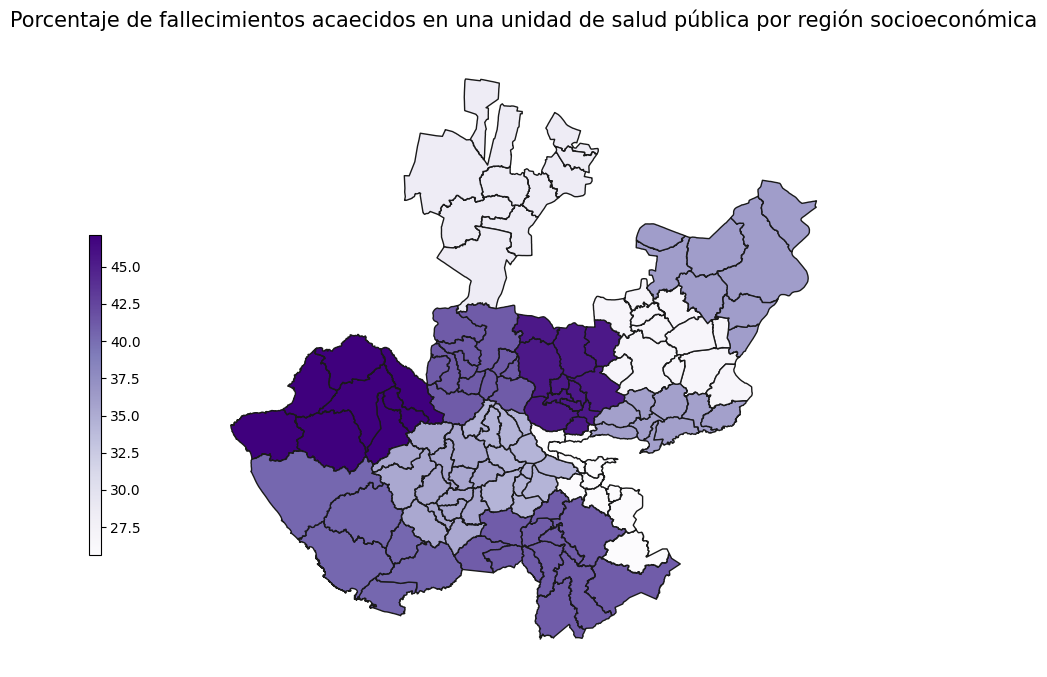

In [22]:
porc_salud_pub_mun=asign_por_mun(porc_salud_pub_reg,num_reg_mod)
mun_jal_map['Acceso_salud_publica']=porc_salud_pub_mun
#Set the range for the choropleth
titulo='Porcentaje de fallecimientos acaecidos en una unidad de salud pública por región socioeconómica'
col='Acceso_salud_publica'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='Purples'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

Registros de aquellos que fallecieron en alguna unidad de salud privada

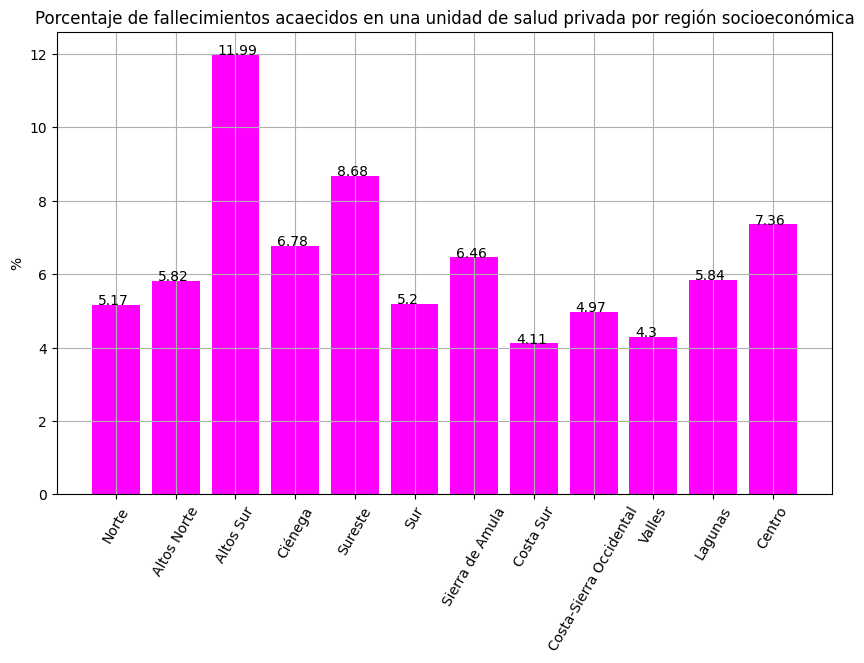

In [23]:
df_salud_priv=df_sitio[df_sitio['sitio_ocur']==9]
count_salud_priv=df_salud_priv.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Calcular el porcentaje de defunciones acaecidas en una unidad de salud pública
porc_salud_priv_reg=(count_salud_priv['mun_resid']/count_sitio['mun_resid'])*100
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,porc_salud_priv_reg,color='magenta')
title("Porcentaje de fallecimientos acaecidos en una unidad de salud privada por región socioeconómica")
tick_params(axis='x', rotation=60)
ylabel('%')
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,porc_salud_priv_reg[i],str(round(porc_salud_priv_reg[i],2)),color="k")
grid()

Esta gráfica se complementa con la anterior, puesto que las dos regiones que en esa gráfica mostraron los dos valores más bajos ahora muestran los dos porcentajes más altos. Entonces, esto podría estar ligado a que, debido a la insuficiencia de servicios de salud públicos, los habitantes de estas dos regiones tienen que acudir a servicios de salud privados. Asimismo, podría indicarnos que la capacidad ecónomica de los habitantesde estas regiones es mayor que la de habitantes de otras regiones.

Representar los mismos resultados a través del mapa

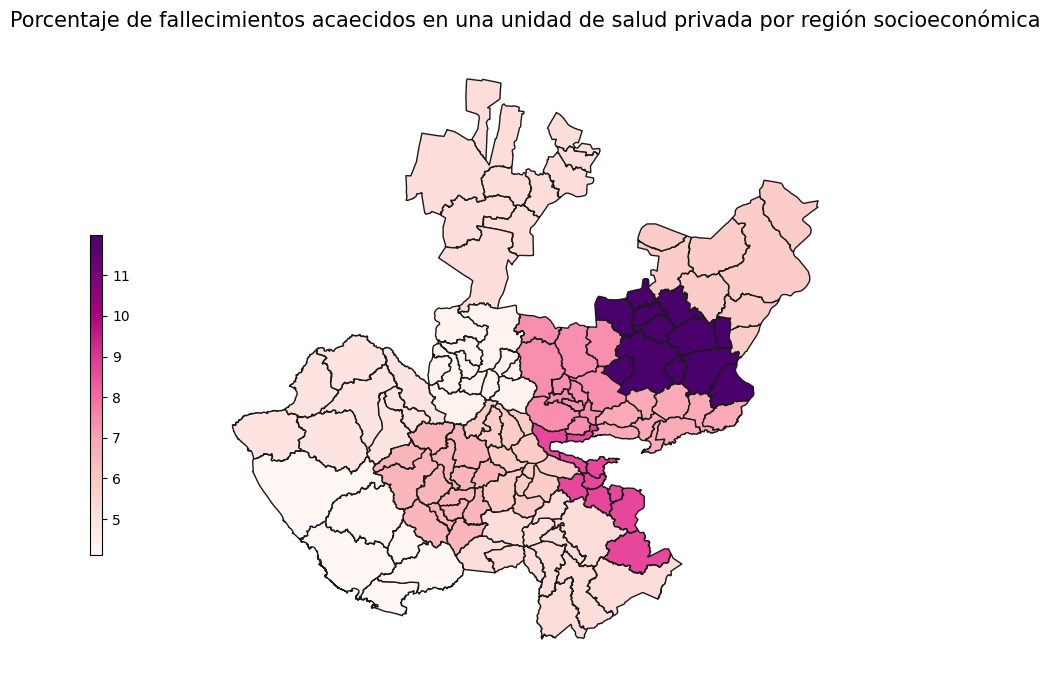

In [24]:
porc_salud_priv_mun=asign_por_mun(porc_salud_priv_reg,num_reg_mod)
mun_jal_map['Acceso_salud_privada']=porc_salud_priv_mun
#Set the range for the choropleth
titulo='Porcentaje de fallecimientos acaecidos en una unidad de salud privada por región socioeconómica'
col='Acceso_salud_privada'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='RdPu'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

Registros de aquellos que fallecieron en vía pública

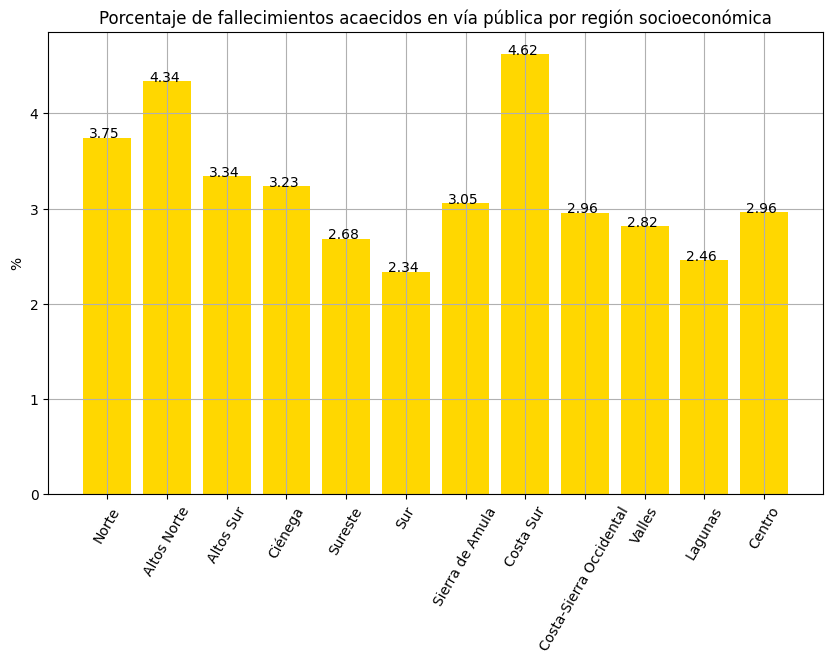

In [25]:
df_via_pub=df_sitio[df_sitio['sitio_ocur']==10]
count_via_pub=df_via_pub.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Calcular el porcentaje de defunciones acaecidas en una unidad de salud pública
porc_via_pub_reg=(count_via_pub['mun_resid']/count_sitio['mun_resid'])*100
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,porc_via_pub_reg,color='gold')
title("Porcentaje de fallecimientos acaecidos en vía pública por región socioeconómica")
ylabel('%')
tick_params(axis='x', rotation=60)
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,porc_via_pub_reg[i],str(round(porc_via_pub_reg[i],2)),color="k")
grid()

Las tres regiones con el porcentaje más alto de defunciones en vía pública son Costa Sur, Altos Norte y Norte. Esto podría indicar que el tiempo de atención a emergencias en estas regiones es más lento, o no existen suficientes unidades de salud.

Representar los resultados a través de un mapa

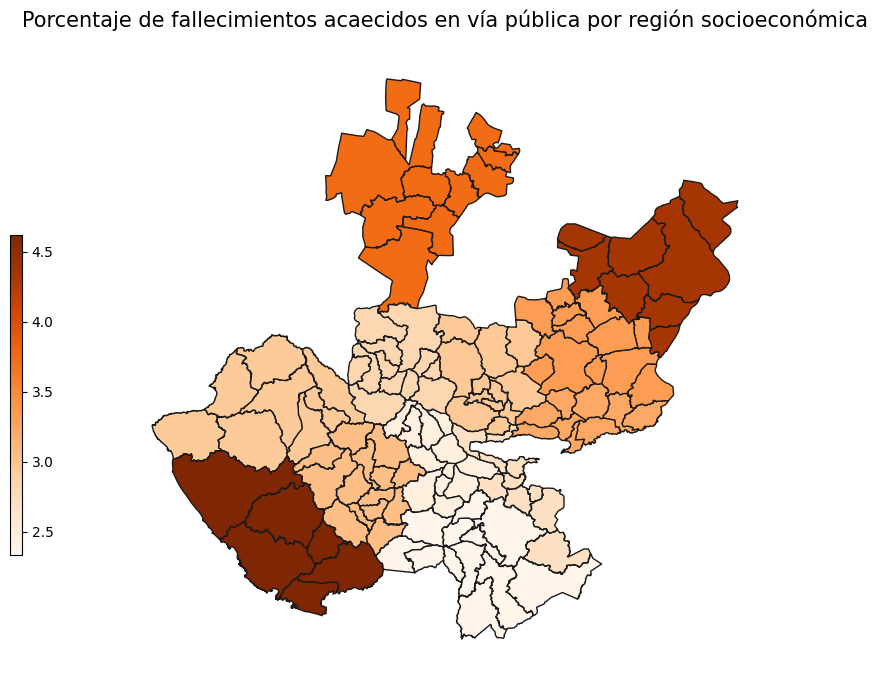

In [26]:
porc_via_pub_mun=asign_por_mun(porc_via_pub_reg,num_reg_mod)
mun_jal_map['Defunciones_via_publica']=porc_via_pub_mun
#Set the range for the choropleth
titulo='Porcentaje de fallecimientos acaecidos en vía pública por región socioeconómica'
col='Defunciones_via_publica'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='Oranges'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

Registros de aquellos que fallecieron en el hogar

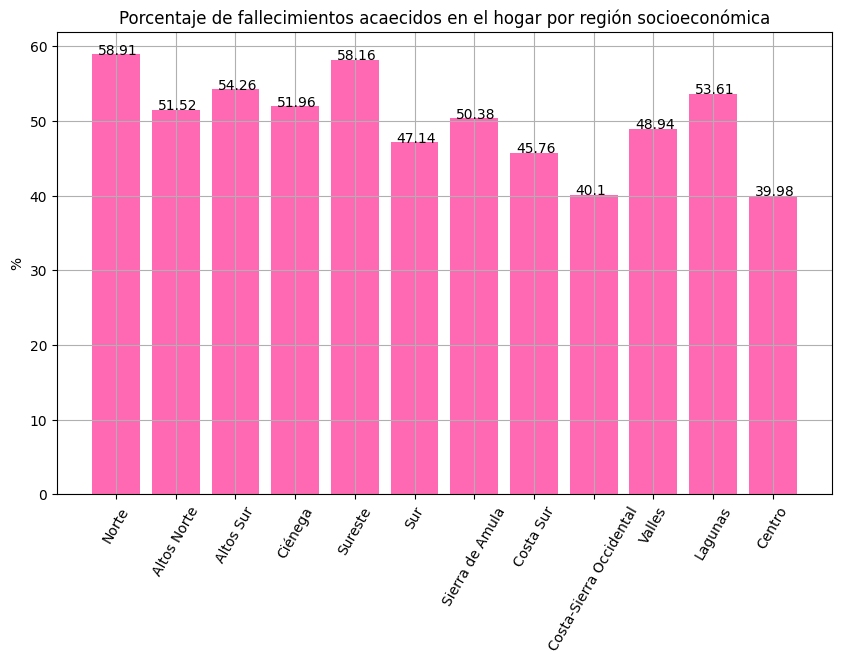

In [27]:
df_hogar=df_sitio[df_sitio['sitio_ocur']==11]
count_hogar=df_hogar.groupby(['No_Region ']).agg({'mun_resid': 'count'}).reset_index()
#Calcular el porcentaje de defunciones acaecidas en el hogar
porc_hogar_reg=(count_hogar['mun_resid']/count_sitio['mun_resid'])*100
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,porc_hogar_reg,color='hotpink')
title("Porcentaje de fallecimientos acaecidos en el hogar por región socioeconómica")
ylabel('%')
tick_params(axis='x', rotation=60)
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.3,porc_hogar_reg[i],str(round(porc_hogar_reg[i],2)),color="k")
grid()

Al igual que en gráficas anteriores, nuevamente las regiones Norte y Sureste son las que muestran los porcentajes más altos. Esto reafirma más la hipótesis de que los servicios de salud pública son más lentos y de más difícil acceso en los municipios que conforman estas regiones.\
Por otro lado, las regiones Centro y Costa-Sierra Occidental son las que muestran los valores más bajos, que se podría asociar nuevamente a que en estas dos regiones la atención en situaciones de emergencia es más eficiente.

Representar los mismos resultados a través de un mapa

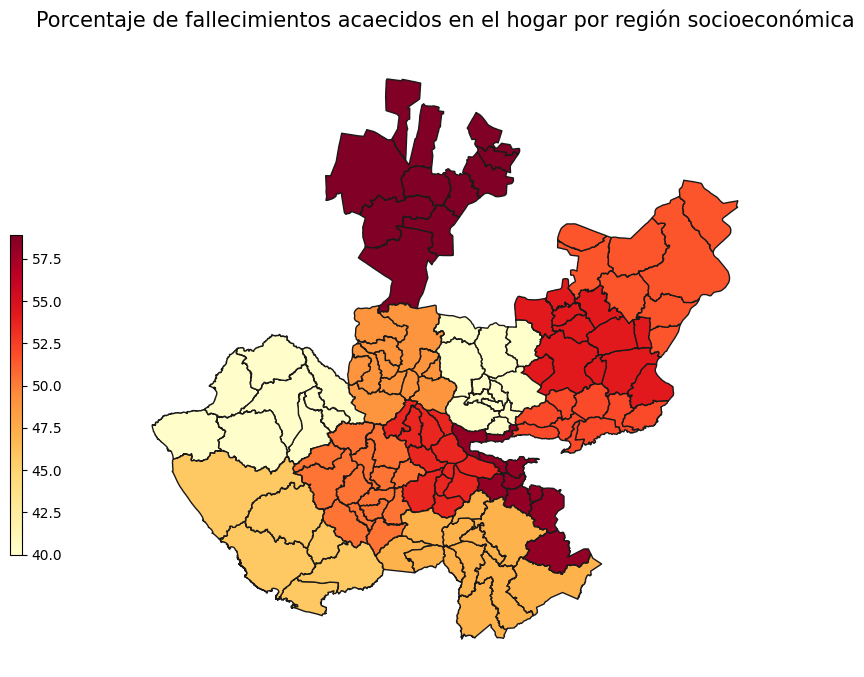

In [28]:
porc_hogar_mun=asign_por_mun(porc_hogar_reg,num_reg_mod)
mun_jal_map['Defunciones_hogar']=porc_hogar_mun
#Set the range for the choropleth
titulo='Porcentaje de fallecimientos acaecidos en el hogar por región socioeconómica'
col='Defunciones_hogar'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='YlOrRd'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '15', 'fontweight': '3'})
#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar=fig.colorbar(sm,cax=cbaxes)

#Número de Unidades de Salud por Región Socioeconómica

Se consultaron los diagnósticos de cada región socioeconómica de Jalisco publicados en agosto de 2022 por el Instituto de Información Estadística y Geográfica de Jalisco (IIEG) y disponibles en el siguiente enlace:\
https://iieg.gob.mx/ns/?page_id=4989 \
Con base en estos datos, se obtuvo el número de unidades médicas existentes en cada región. Como se mostrará a continuación, esto respalda varias de las conclusiones presentadas en las gráficas anteriores donde únicamente se usaron datos de defunciones.\
Cabe resaltar, que no se usó el número total de unidades que proporcionan servicios de salud porque incluyen consultorios médicos (privados y públicos), unidades móviles y algunas otras unidades con poca capacidad de atención que sesgan los resultados respecto a la accesibilidad de servicios de salud en situaciones críticas. Por lo tanto, sólo se consideraron unidades médicas, clínicas, hospitales, unidades de especialidades médicas y casas de salud.\
Asimismo, en el diagnóstico publicado para la **región Costa Sur** se encontró un **error en la información presentada** respecto al número de unidades de salud privadas, ya que este coincide perfectamente con cada tipo y cantidad de unidades de salud privadas de la región Centro (lo cual es imposible).

Número de unidades de salud públicas por cada región socioeconómica

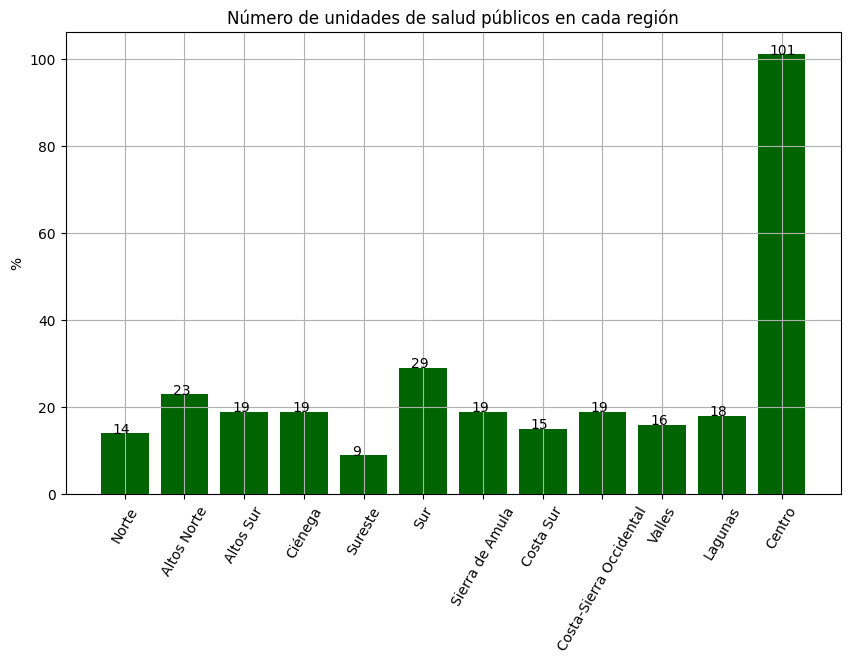

In [29]:
unid_pub_reg=[14,23,19,19,9,29,19,15,19,16,18,101]
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,unid_pub_reg,color='darkgreen')
title("Número de unidades de salud públicos en cada región")
ylabel('%')
tick_params(axis='x', rotation=60)
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.2,unid_pub_reg[i],str(round(unid_pub_reg[i],2)),color="k")
grid()

En esta gráfica podemos confirmar cómo la región Centro posee una enorme cantidad de unidades de salud, lo cual era de esperarse porque en esta región se debe prestar atención médica a cerca de 5 millones de habitantes.\
Por otro lado, como se había concluido a partir de gráficas previas, aquí podemos ver que las regiones Norte y Sureste poseen pocas unidades de salud públicas, y por lo tanto, la atención en situaciones graves o de emergencia está muy limitada.

Número de unidades de salud privadas por cada región socioeconómica

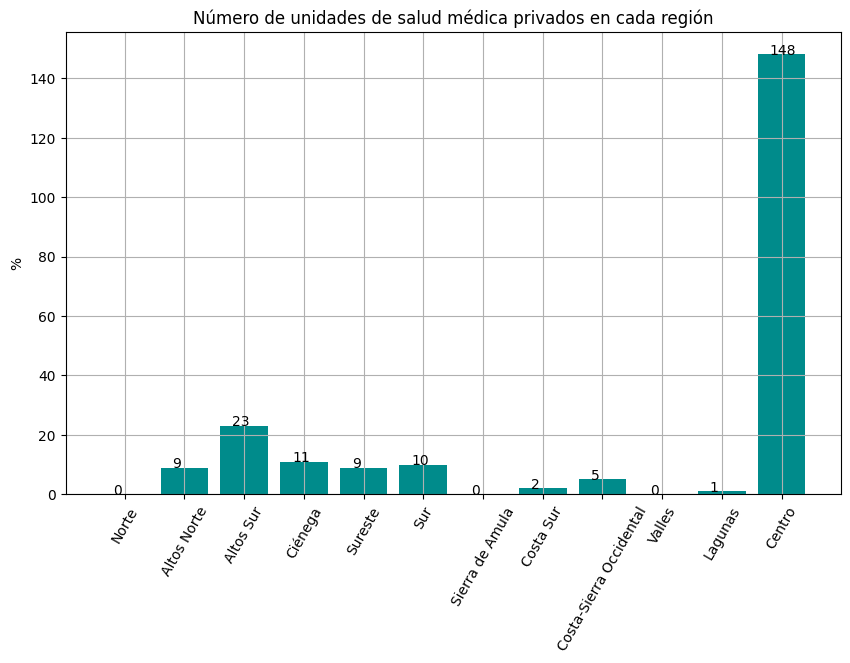

In [30]:
#Falta verificar que efectivamente son 2, porque la información disponible tiene errores en el caso de Costa Sur
unid_priv_reg=[0,9,23,11,9,10,0,2,5,0,1,148]
#Realizar histograma
figure(figsize=(10,6))
bar(nombres,unid_priv_reg,color='darkcyan')
title("Número de unidades de salud médica privados en cada región")
ylabel('%')
tick_params(axis='x', rotation=60)
#Agregar etiquetas de los valores a cada barra
for i in range(0,12):
    text(i-0.2,unid_priv_reg[i],str(round(unid_priv_reg[i],2)),color="k")
grid()

En esta gráfica se valida nuevamente una de las hipótesis previas: la región Altos Sur posee una cantidad importante de unidades de salud privadas, superando incluso el número de unidades de salud públicas.